In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from ewtpy import EWT1D

In [4]:
def get_mat_voltage(plot=False):
    """
    sampling rate: 10Hz
    """
    filepath = "Cycling_1/V4.mat"
    f = loadmat(filepath)
    # print(f.keys())

    current = f['I_full_vec_M1_NMC25degC']
    time = f['t_full_vec_M1_NMC25degC']
    voltage = f['V_full_vec_M1_NMC25degC']
    step = f['Step_Index_full_vec_M1_NMC25degC']
    if plot:
        plt.plot(step[np.arange(5000)*10], c='black')
        plt.plot(voltage[np.arange(5000)*10], c='blue')
        plt.xlabel('time(s)')
        plt.show()
        plt.close()
    return voltage, step

discharge segments=20


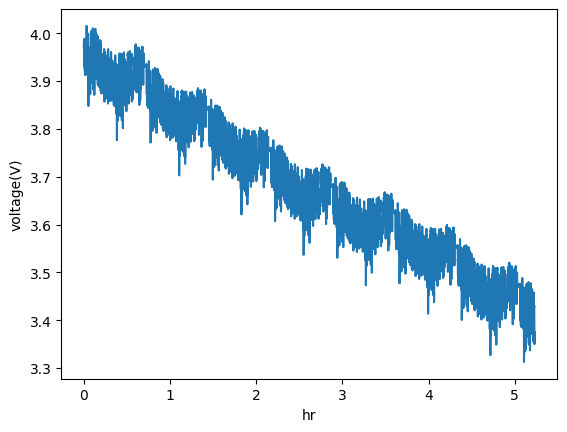

In [9]:
v, s = get_mat_voltage()

# extract discharge part
v[s!=14] = 0
dif = np.abs(np.diff(v, axis=0))
edge = np.argwhere(dif>1)+1
dc_v = [v[edge[i, 0]:edge[i+1, 0]] for i in range(0, len(edge), 2)]
print('discharge segments=%d'%len(dc_v))
plt.plot(np.arange(len(dc_v[0]))/36000, dc_v[0])
plt.xlabel('hr')
plt.ylabel('voltage(V)')
plt.show()
plt.close()

(36000, 9)
(71999, 9)


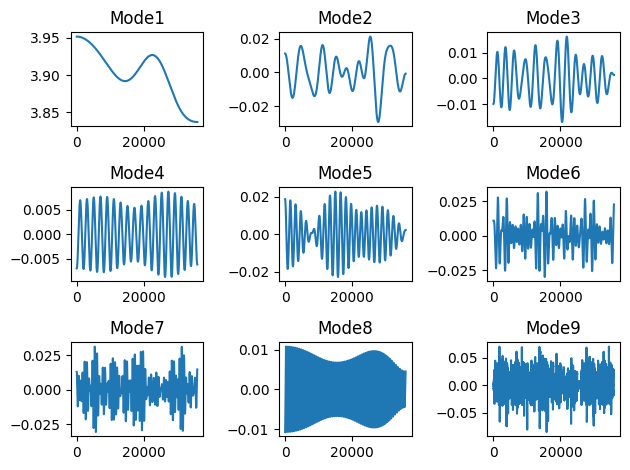

In [50]:
# extract voltage information within 1hr to apply EWT
ewt, mfb ,boundaries = EWT1D(dc_v[0][:36000, 0], N=9)
print(ewt.shape)
print(mfb.shape)
fig, ax = plt.subplots(3, 3)
for i in range(9):
    ax[i//3,i%3].plot(ewt[:, i])
    ax[i//3,i%3].set_title('Mode%d'%(i+1))
plt.tight_layout()
plt.show()
plt.close()